# 事前準備

In [2]:
import os
import psutil
import numpy as np
import pandas as pd
import multiprocessing
import matplotlib.pyplot as plt
import japanize_matplotlib

from sklearn import preprocessing

import mca

import sklearn
import lightgbm

DATA_PATH = os.getcwd()+'/data/'
SUBMISSION_PATH = os.getcwd()+'/submission/'

In [3]:
train_data = pd.read_csv(DATA_PATH+'train.csv', dtype=np.int16).drop('Id',axis=1)
test_data = pd.read_csv(DATA_PATH+'test.csv', dtype=np.int16).drop('Id',axis=1)

In [4]:
# メモリ容量を取得
mem = psutil.virtual_memory()
print(mem.total)
print(mem.available)

134854402048
109237252096


# データの確認

In [5]:
train_data

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,3189,40,8,30,13,3270,206,234,193,4873,...,0,0,0,0,0,0,0,0,0,1
1,3026,182,5,280,29,3270,233,240,106,5423,...,0,0,0,0,0,0,0,0,0,2
2,3106,13,7,351,37,2914,208,234,137,5269,...,0,0,0,0,0,0,0,0,0,1
3,3022,276,13,192,16,3034,207,238,156,2866,...,0,0,0,0,0,0,0,0,0,2
4,2906,186,13,266,22,2916,231,231,154,2642,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,2954,34,25,51,65,6314,240,237,103,1618,...,0,0,0,0,0,0,0,0,0,2
3999996,2926,104,8,696,83,5427,210,216,150,2863,...,0,0,0,0,0,0,0,0,0,2
3999997,2911,144,1,509,58,4820,195,192,91,92,...,0,0,0,0,0,0,0,1,0,2
3999998,2580,178,17,376,86,2592,225,183,39,1374,...,0,0,0,0,0,0,0,0,0,3


In [25]:
# 欠損値チェック
train_data.isnull().any()

Elevation                             False
Aspect                                False
Slope                                 False
Horizontal_Distance_To_Hydrology      False
Vertical_Distance_To_Hydrology        False
Horizontal_Distance_To_Roadways       False
Hillshade_9am                         False
Hillshade_Noon                        False
Hillshade_3pm                         False
Horizontal_Distance_To_Fire_Points    False
Wilderness_Area1                      False
Wilderness_Area2                      False
Wilderness_Area3                      False
Wilderness_Area4                      False
Soil_Type1                            False
Soil_Type2                            False
Soil_Type3                            False
Soil_Type4                            False
Soil_Type5                            False
Soil_Type6                            False
Soil_Type7                            False
Soil_Type8                            False
Soil_Type9                      

In [6]:
test_data

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,2763,78,20,377,88,3104,218,213,195,1931,...,0,0,0,0,0,0,0,0,0,0
1,2826,153,11,264,39,295,219,238,148,2557,...,0,0,0,0,0,0,0,0,0,0
2,2948,57,19,56,44,852,202,217,163,1803,...,0,0,1,0,0,0,0,0,0,0
3,2926,119,6,158,134,2136,234,240,142,857,...,0,0,0,0,0,0,0,0,0,0
4,2690,10,4,38,108,3589,213,221,229,431,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2974,254,15,146,100,623,222,245,117,2353,...,0,0,0,0,0,0,0,0,0,0
999996,3180,92,16,93,47,3740,209,201,142,356,...,0,0,0,0,0,0,0,0,1,0
999997,2684,51,20,34,123,962,199,225,145,350,...,0,0,0,0,1,0,0,0,0,0
999998,3309,64,12,196,93,2522,226,193,74,3300,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# 欠損値チェック
test_data.isnull().any()

Elevation                             False
Aspect                                False
Slope                                 False
Horizontal_Distance_To_Hydrology      False
Vertical_Distance_To_Hydrology        False
Horizontal_Distance_To_Roadways       False
Hillshade_9am                         False
Hillshade_Noon                        False
Hillshade_3pm                         False
Horizontal_Distance_To_Fire_Points    False
Wilderness_Area1                      False
Wilderness_Area2                      False
Wilderness_Area3                      False
Wilderness_Area4                      False
Soil_Type1                            False
Soil_Type2                            False
Soil_Type3                            False
Soil_Type4                            False
Soil_Type5                            False
Soil_Type6                            False
Soil_Type7                            False
Soil_Type8                            False
Soil_Type9                      

(array([1.468136e+06, 2.262087e+06, 0.000000e+00, 1.957120e+05,
        0.000000e+00, 3.770000e+02, 1.000000e+00, 0.000000e+00,
        1.142600e+04, 6.226100e+04]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

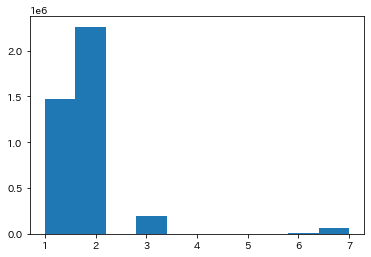

In [7]:
plt.hist(train_data['Cover_Type'])

In [8]:
print('------------- train data -------------')
for i in range(7):
    print("Cover_Type{}: {}".format(i+1, len(train_data[train_data['Cover_Type']==(i+1)])))

------------- train data -------------
Cover_Type1: 1468136
Cover_Type2: 2262087
Cover_Type3: 195712
Cover_Type4: 377
Cover_Type5: 1
Cover_Type6: 11426
Cover_Type7: 62261


# わかったこと

- 不均衡データによる多クラス分類  
  → 評価関数を工夫する  
  → マージン最大化を利用する  
  → ダウンサンプリング(Type4に合わせる)
- 説明変数の一部がスパース  
  → 多重対応分析による特徴量抽出  

# ベースライン

## 前処理

In [66]:
#説明変数
train_ex = train_data.drop('Cover_Type', axis=1)
#目的変数
train_ob = train_data['Cover_Type']

In [64]:
# 標準化
ss = preprocessing.StandardScaler()
train_ss = pd.DataFrame(ss.fit_transform(train_ex), index=train_ex.index, columns=train_ex.columns)

In [70]:
# 標準化
ss = preprocessing.StandardScaler()
test_ss = pd.DataFrame(ss.fit_transform(test_data), index=test_data.index, columns=test_data.columns)

In [65]:
train_ss

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,0.722400,-1.014774,-0.830439,-1.065177,-0.566768,1.142708,-0.189777,0.581997,1.194297,2.919073,...,-0.168138,-0.197282,-0.198261,-0.110185,-0.127732,-0.104061,-0.111168,-0.206113,-0.202094,-0.180696
1,0.158480,0.276592,-1.181450,0.038334,-0.332219,1.142708,0.687987,0.851886,-0.796612,3.406827,...,-0.168138,-0.197282,-0.198261,-0.110185,-0.127732,-0.104061,-0.111168,-0.206113,-0.202094,-0.180696
2,0.435250,-1.260315,-0.947443,0.351731,-0.214944,0.872111,-0.124758,0.581997,-0.087208,3.270256,...,-0.168138,-0.197282,-0.198261,-0.110185,-0.127732,-0.104061,-0.111168,-0.206113,-0.202094,-0.180696
3,0.144641,1.131439,-0.245420,-0.350102,-0.522790,0.963324,-0.157268,0.761923,0.347588,1.139212,...,-0.168138,-0.197282,-0.198261,-0.110185,-0.127732,-0.104061,-0.111168,-0.206113,-0.202094,-0.180696
4,-0.256676,0.312968,-0.245420,-0.023463,-0.434834,0.873632,0.622968,0.447052,0.301820,0.940562,...,-0.168138,-0.197282,-0.198261,-0.110185,-0.127732,-0.104061,-0.111168,-0.206113,-0.202094,-0.180696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,-0.090613,-1.069339,1.158626,-0.972482,0.195517,3.456465,0.915556,0.716941,-0.865264,0.032452,...,-0.168138,-0.197282,-0.198261,-0.110185,-0.127732,-0.104061,-0.111168,-0.206113,-0.202094,-0.180696
3999996,-0.187483,-0.432750,-0.830439,1.874576,0.459385,2.782252,-0.059738,-0.227671,0.210284,1.136551,...,-0.168138,-0.197282,-0.198261,-0.110185,-0.127732,-0.104061,-0.111168,-0.206113,-0.202094,-0.180696
3999997,-0.239378,-0.068985,-1.649466,1.049150,0.092902,2.320869,-0.547385,-1.307229,-1.139873,-1.320846,...,-0.168138,-0.197282,-0.198261,-0.110185,-0.127732,-0.104061,-0.111168,-0.206113,4.948200,-0.180696
3999998,-1.384516,0.240215,0.222595,0.462082,0.503363,0.627358,0.427909,-1.712063,-2.329841,-0.183934,...,-0.168138,-0.197282,-0.198261,-0.110185,-0.127732,-0.104061,-0.111168,-0.206113,-0.202094,-0.180696


In [71]:
test_ss

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,-0.602909,-0.664981,0.600277,0.494061,0.532977,1.011325,0.202692,-0.386123,1.214559,0.219114,...,-0.174766,-0.213039,-0.205730,-0.110926,-0.126564,-0.103974,-0.1105,-0.212982,-0.203701,-0.184089
1,-0.419062,0.006883,-0.463930,-0.001615,-0.182141,-1.031701,0.234661,0.752728,0.179271,0.735520,...,-0.174766,-0.213039,-0.205730,-0.110926,-0.126564,-0.103974,-0.1105,-0.212982,-0.203701,-0.184089
2,-0.063040,-0.853103,0.482031,-0.914009,-0.109170,-0.626587,-0.308810,-0.203907,0.509682,0.113523,...,-0.174766,-0.213039,4.860751,-0.110926,-0.126564,-0.103974,-0.1105,-0.212982,-0.203701,-0.184089
3,-0.127241,-0.297695,-1.055157,-0.466585,1.204312,0.307285,0.714194,0.843836,0.047107,-0.666860,...,-0.174766,-0.213039,-0.205730,-0.110926,-0.126564,-0.103974,-0.1105,-0.212982,-0.203701,-0.184089
4,-0.815938,-1.274138,-1.291647,-0.992966,0.824862,1.364072,0.042848,-0.021691,1.963491,-1.018280,...,-0.174766,-0.213039,-0.205730,-0.110926,-0.126564,-0.103974,-0.1105,-0.212982,-0.203701,-0.184089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0.012833,0.911661,0.009050,-0.519223,0.708108,-0.793142,0.330568,1.071607,-0.503579,0.567235,...,-0.174766,-0.213039,-0.205730,-0.110926,-0.126564,-0.103974,-0.1105,-0.212982,-0.203701,-0.184089
999996,0.613984,-0.539567,0.127296,-0.751708,-0.065388,1.473897,-0.085028,-0.932772,0.047107,-1.080150,...,-0.174766,-0.213039,-0.205730,-0.110926,-0.126564,-0.103974,-0.1105,-0.212982,4.909152,-0.184089
999997,-0.833448,-0.906852,0.600277,-1.010512,1.043775,-0.546582,-0.404717,0.160525,0.113189,-1.085100,...,-0.174766,-0.213039,-0.205730,-0.110926,7.901116,-0.103974,-0.1105,-0.212982,-0.203701,-0.184089
999998,0.990433,-0.790396,-0.345685,-0.299898,0.605948,0.588028,0.458443,-1.297204,-1.450757,1.348443,...,-0.174766,-0.213039,-0.205730,-0.110926,-0.126564,-0.103974,-0.1105,-0.212982,-0.203701,-0.184089


## モデル

In [68]:
lgbm = lightgbm.LGBMClassifier()

In [69]:
lgbm.fit(train_ss, train_ob)

LGBMClassifier()

In [73]:
y_pred = lgbm.predict(test_ss)

In [79]:
submission = pd.DataFrame([np.arange(4000000,5000000), y_pred], index=['Id','Cover_Type']).T

In [83]:
submission.to_csv(SUBMISSION_PATH+"baseline.csv", index=False)

評価値: 0.89983

# 実験

やることとして
1. 全データを対象に，バイナリ変数に多重対応分析
1. 全データに対して標準化を適用
1. trainデータをダウンサンプリング(Type:4に合わせる) 
1. ここで，trainとtestを別途保存する
1. アンサンブル学習(LightGBM, SVMとか？)  
    1. パラメータチューニング
1. testデータの適用

## 多重対応分析

In [ ]:
#mca_counts = mca.MCA(playlist)
mca_counts = mca.MCA(df_json.astype(float))
 
# 結果データ抜き出し
# 2次元表示のためN=2まで
rows = mca_counts.fs_r(N=2)  # 表側データ
cols = mca_counts.fs_c(N=2)  # 表頭データ

In [ ]:
# 表側
plt.scatter(rows[:, 0], rows[:, 1], c='b', marker="None")
labels = playlist.index
for label, x, y in zip(labels, rows[:, 0], rows[:, 1]):
    plt.annotate(label, xy=(x, y), c="b")
    
# 表頭
plt.scatter(cols[:, 0], cols[:, 1], c='r', marker="None")
labels = playlist.columns[1:]
print(len(labels))
for label, x, y in zip(labels, cols[:, 0], cols[:, 1]):
    plt.annotate(label, xy=(x, y), c="r")
 
# xy軸
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')

In [ ]:
# 特徴量
fun_features = pd.DataFrame(rows).set_index(playlist.index)
fun_features

## ダウンサンプリング

## アンサンブル学習